<a href="https://colab.research.google.com/github/MithunKiniStar/AutoEncodersFaceSketch/blob/main/4_Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Conditional Generative Adversarial Nets (cGAN)

Acknoledgement - This work is refered from https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb#scrollTo=DMTm4peo3

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display
import cv2 as cv

In [2]:
!pip install keras==2.1.0
!pip install tensorflow==2.1.0

     |████████████████████████████████| 302 kB 10.5 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.1.0 which is incompatible.


     |████████████████████████████████| 421.8 MB 25 kB/s 
     |████████████████████████████████| 3.8 MB 73.4 MB/s 
     |████████████████████████████████| 448 kB 67.3 MB/s 
     |████████████████████████████████| 50 kB 8.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=56c1bd96e22a942e793e756e0882b1c13b0941f810fdec54563b845f8f2b7cd7
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

In [3]:
print(tf.__version__)

2.1.0


In [4]:
import scipy
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate,concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU,ReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D,Conv2DTranspose
from tensorflow.keras import Sequential, Model
from keras.optimizers import Adam
import datetime
import sys
# from data_loader import DataLoader
import numpy as np
import os
import cv2 as cv

Using TensorFlow backend.


In [5]:
!mkdir -p dataset


In [6]:
path ='/content/dataset'

In [7]:
cd '/content/dataset'

/content/dataset


In [ ]:
pwd

'/content/dataset'

In [8]:
!mkdir -p pix2pix/test/concat
!mkdir -p pix2pix/train/concat
!mkdir -p pix2pix/test_face_to_sketch/concat
!mkdir -p pix2pix/train_face_to_sketch/concat

In [9]:
_URL1 = 'http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/training_88/Cropped_Images/CUHK_training_cropped_sketches.zip'

_URL2 = 'http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/training_88/Cropped_Images/CUHK_training_cropped_photos.zip'

_URL3 = 'http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/testing_100/Cropped_Images/CUHK_testing_cropped_sketches.zip'

_URL4 = 'http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/testing_100/Cropped_Images/CUHK_testing_cropped_photos.zip'

path_to_zip1 = tf.keras.utils.get_file(path+'/pix2pix/train/CUHK_training_cropped_sketches.zip',
                                      origin=_URL1,archive_format='zip',
                                       cache_subdir=path+'/pix2pix/train',
                                      extract=True)

path_to_zip2 = tf.keras.utils.get_file(path+'/pix2pix/train/CUHK_training_cropped_photos.zip',
                                      origin=_URL2,archive_format='zip',
                                       cache_subdir=path+'/pix2pix/train',
                                      extract=True)

path_to_zip3 = tf.keras.utils.get_file(path+'/pix2pix/test/CUHK_testing_cropped_sketches.zip',
                                       cache_subdir=path+'/pix2pix/test',
                                      origin=_URL3,
                                      extract=True)

path_to_zip4 = tf.keras.utils.get_file(path+'/pix2pix/test/CUHK_testing_cropped_photos.zip',
                                      origin=_URL4,
                                       cache_subdir=path+'/pix2pix/test',
                                      extract=True)

778240/771222 [==============================] - 1s 1us/step


In [10]:
PATH1 = os.path.join(os.path.dirname(path_to_zip1), 'sketches/')

PATH2 = os.path.join(os.path.dirname(path_to_zip2), 'photos/')

PATH3 = os.path.join(os.path.dirname(path_to_zip3), 'sketches/')

PATH4 = os.path.join(os.path.dirname(path_to_zip4), 'photos/')

**Data Preprocessing**

In [11]:
def numpyimage(sketch_image_file, original_image):
  image1 = cv.imread(sketch_image_file)
  image2 = cv.imread(original_image)
  return image1, image2

In [12]:
def load(sketch_image_file, original_image):
  # image1 = cv.imread(sketch_image_file)
  # image2 = cv.imread(original_image)
  image1 = tf.io.read_file(sketch_image_file)
  image1 = tf.image.decode_jpeg(image1,channels=3)


  image2 = tf.io.read_file(original_image)
  image2 = tf.image.decode_jpeg(image2,channels=3)

  
  image1 = tf.cast(image1, tf.float32)
  image2 = tf.cast(image2, tf.float32)

  return image1, image2

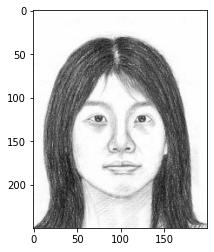

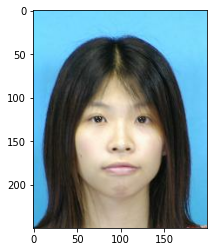

In [13]:
inp, re = load(PATH1+'F2-005-01-sz1.jpg', PATH2+'f-005-01.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [14]:
print(re.shape)

print(inp.shape)

(250, 200, 3)
(250, 200, 3)


In [15]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [16]:
def random_jitter(input_image, real_image):
  # resizing to 256 x 256 x 3
  input_image, real_image = resize(input_image, real_image, 256, 256)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [17]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

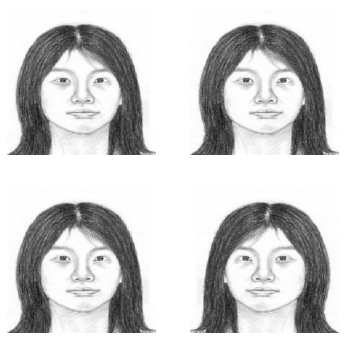

In [18]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255)
  plt.axis('off')
plt.show()

In [19]:
rj_inp.shape

TensorShape([256, 256, 3])

In [20]:
import glob
train_sketch = glob.glob(path+"/pix2pix/train/sketches/*")
train_photo = glob.glob(path+"/pix2pix/train/photos/*")

In [21]:
test_sketch = glob.glob(path+"/pix2pix/test/sketches/*")
test_photo = glob.glob(path+"/pix2pix/test/photos/*")

In [22]:
train_sketch = sorted(train_sketch)
train_photo = sorted(train_photo)

In [23]:
test_sketch = sorted(test_sketch)
test_photo = sorted(test_photo)

**Data Preparation For Sketch To Face Generation**

In [24]:
train=[]
for i in range(0,88):
  train.append(train_sketch[i]+' '+train_photo[i])

In [25]:
test=[]
for i in range(0,100):
  test.append(test_sketch[i]+' '+test_photo[i])

In [26]:
j=0
for i in train:
  im = i.split(' ')
  # print(im)
  im[0],im[1] = numpyimage(im[0], im[1])
  im_v = cv.hconcat([im[0], im[1]])
  cv.imwrite(path+'/pix2pix/train/concat/'+str(j)+'_merged.jpg', im_v)
  # plt.figure()
  # # plt.imshow(im_v/255.0)
  j = j+1

In [27]:
j=0
for i in test:
  im = i.split(' ')
  # print(im)
  im[0],im[1] = numpyimage(im[0], im[1])
  im_v = cv.hconcat([im[0], im[1]])
  cv.imwrite(path+'/pix2pix/test/concat/'+str(j)+'_merged.jpg', im_v)
  # plt.figure()
  # # plt.imshow(im_v/255.0)
  j = j+1

**Data Preparation For Face To Sketch Generation**

In [28]:
train_face_to_sketch=[]
for i in range(0,88):
  train_face_to_sketch.append(train_photo[i]+' '+train_sketch[i])

In [29]:
test_face_to_sketch=[]
for i in range(0,100):
  test_face_to_sketch.append(test_photo[i]+' '+test_sketch[i])

In [30]:
j=0
for i in train_face_to_sketch:
  im = i.split(' ')
  # print(im)
  im[0],im[1] = numpyimage(im[0], im[1])
  im_v = cv.hconcat([im[0], im[1]])
  cv.imwrite(path+'/pix2pix/train_face_to_sketch/concat/'+str(j)+'_merged.jpg', im_v)
  # plt.figure()
  # # plt.imshow(im_v/255.0)
  j = j+1

In [31]:
j=0
for i in test_face_to_sketch:
  im = i.split(' ')
  # print(im)
  im[0],im[1] = numpyimage(im[0], im[1])
  im_v = cv.hconcat([im[0], im[1]])
  cv.imwrite(path+'/pix2pix/test_face_to_sketch/concat/'+str(j)+'_merged.jpg', im_v)
  # plt.figure()
  # # plt.imshow(im_v/255.0)
  j = j+1

In [32]:
BUFFER_SIZE = 400
BATCH_SIZE = 10
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [33]:
def load2(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  input_image = image[:, :w, :]
  real_image = image[:, w:, :]
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [34]:
def load_image_train(image_file):
  input_image, real_image = load2(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [35]:
def load_image_test(image_file):
  input_image, real_image = load2(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

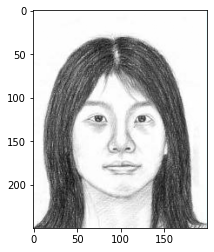

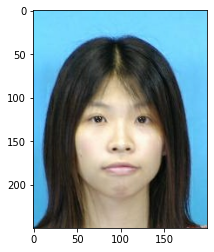

In [36]:
inp, re = load2(path+'/pix2pix/train/concat/0_merged.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

**Preparing Train and Test dataset for Sketch To Face**

In [37]:
train_dataset = tf.data.Dataset.list_files(path+'/pix2pix/train/concat/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [38]:
test_dataset = tf.data.Dataset.list_files(path+'/pix2pix/test/concat/*.jpg')
test_dataset = test_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

**Preparing Train and Test dataset for Face To Sketch**

In [39]:
train_dataset_f2s = tf.data.Dataset.list_files(path+'/pix2pix/train_face_to_sketch/concat/*.jpg')
train_dataset_f2s = train_dataset_f2s.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset_f2s = train_dataset_f2s.shuffle(BUFFER_SIZE)
train_dataset_f2s = train_dataset_f2s.batch(BATCH_SIZE)

In [40]:
test_dataset_f2s = tf.data.Dataset.list_files(path+'/pix2pix/test_face_to_sketch/concat/*.jpg')
test_dataset_f2s = test_dataset_f2s.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset_f2s = test_dataset_f2s.shuffle(BUFFER_SIZE)
test_dataset_f2s = test_dataset_f2s.batch(BATCH_SIZE)

**Build Generator**

In [41]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = Sequential()
  result.add(Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
  if apply_batchnorm:
    result.add(BatchNormalization())
  result.add(LeakyReLU())
  return result

In [42]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = Sequential()
  result.add(Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  result.add(BatchNormalization())
  if apply_dropout:
      result.add(Dropout(0.5))
  result.add(ReLU())
  return result

In [43]:
def Generator():
  inputs = Input(shape=[256,256,3])
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]
  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = Concatenate()([x, skip])
  x = last(x)
  return Model(inputs=inputs, outputs=x)

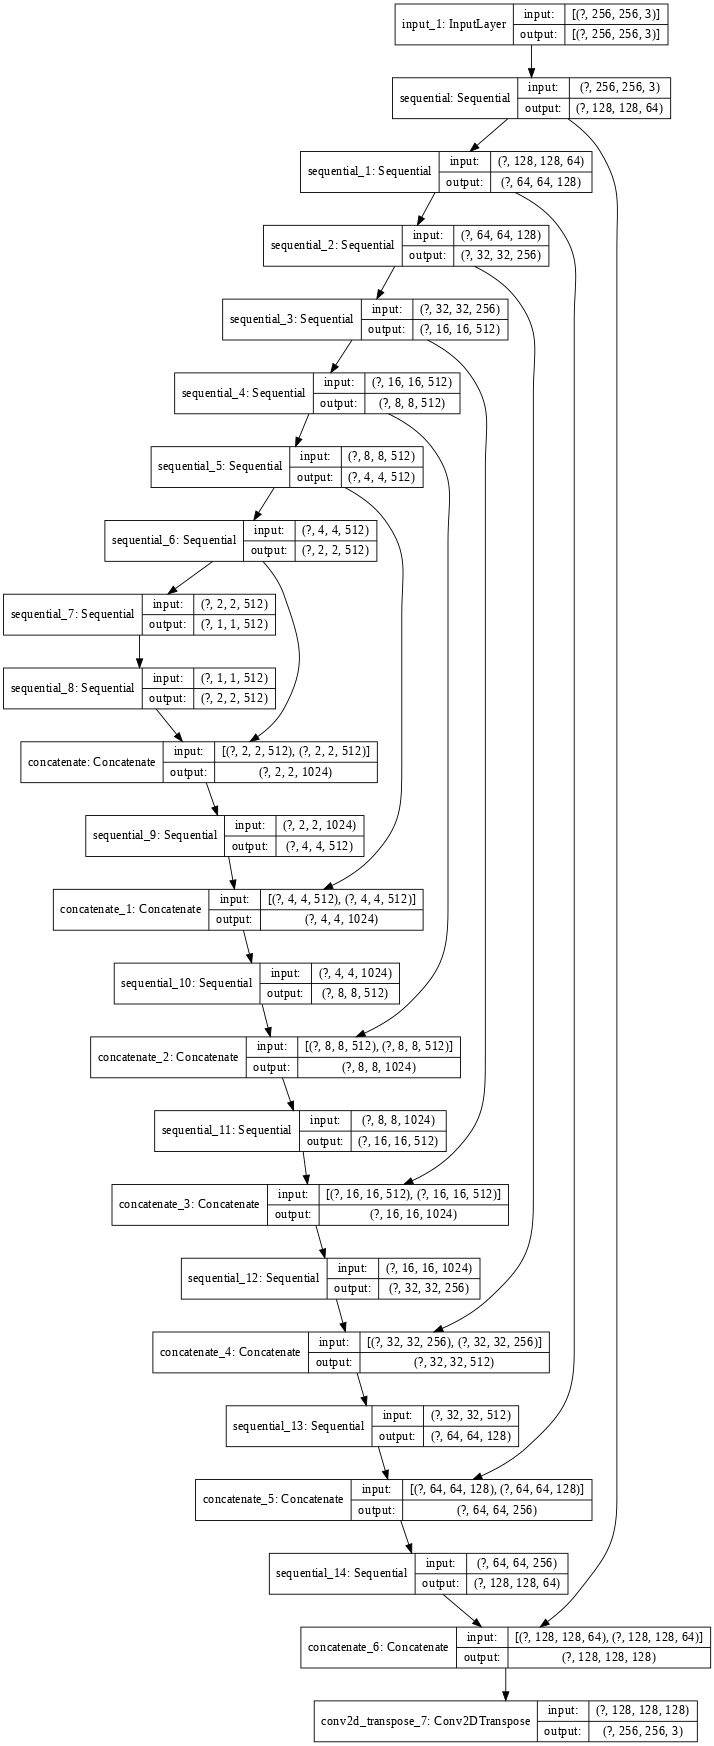

In [44]:
OUTPUT_CHANNELS = 3
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


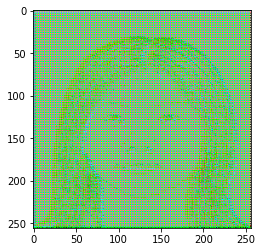

In [45]:
gen_output = generator(rj_inp[tf.newaxis,...])
plt.imshow(gen_output[0,...])

In [46]:
LAMBDA = 100 

In [47]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [48]:
def generator_acc(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

**Build Discriminator**

In [49]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = Input(shape=[256, 256, 3], name='input_image')
  tar = Input(shape=[256, 256, 3], name='target_image')

  x = concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = BatchNormalization()(conv)

  leaky_relu = LeakyReLU()(batchnorm1)

  zero_pad2 = ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return Model(inputs=[inp, tar], outputs=last)

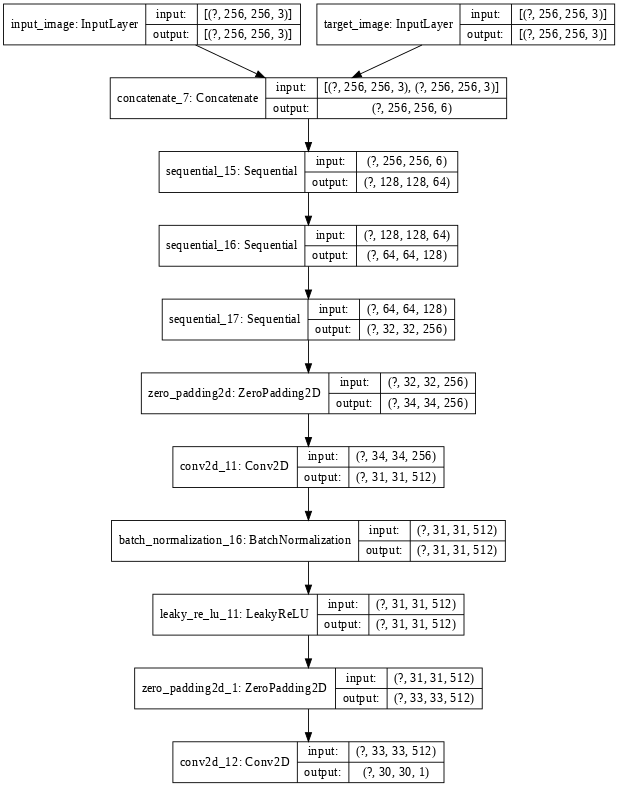

In [50]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

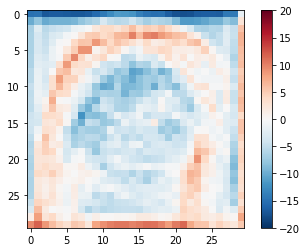

In [52]:
disc_out = discriminator([rj_inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [53]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [54]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [55]:
checkpoint_dir = '/content/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Below function is to see the output of the images from the model

In [56]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  disc_out1 = discriminator([test_input[...], prediction], training=True)
  disc_out2 = discriminator([test_input[...], tar], training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0],disc_out1[0][...,-1],disc_out2[0][...,-1]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image','Discriminator fake','Discriminator real']

  for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

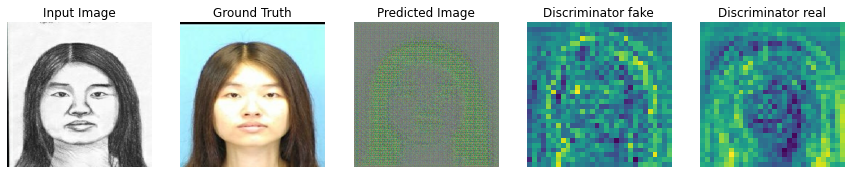

In [57]:
# we predict the image when model is untrained at the begining
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

**Training**

In [58]:
EPOCHS = 10

In [59]:
import datetime
log_dir=path+"/pix2pix/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [60]:
pwd

'/content/dataset'

In [62]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)
    
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [63]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    # display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()


  checkpoint.save(file_prefix = checkpoint_prefix)

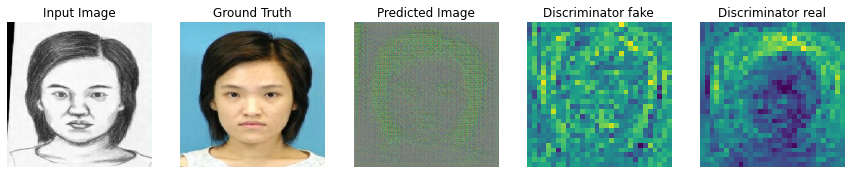

Epoch:  0
.........


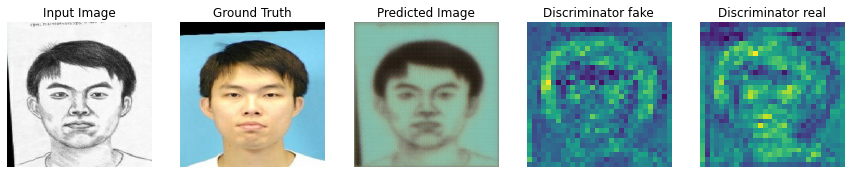

Epoch:  1
.........


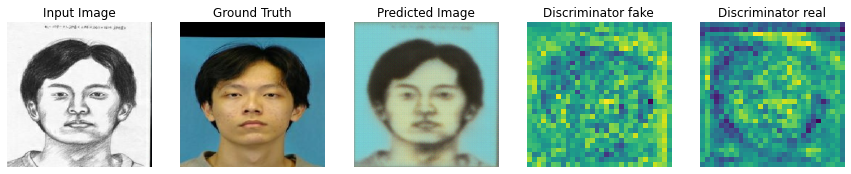

Epoch:  2
.........


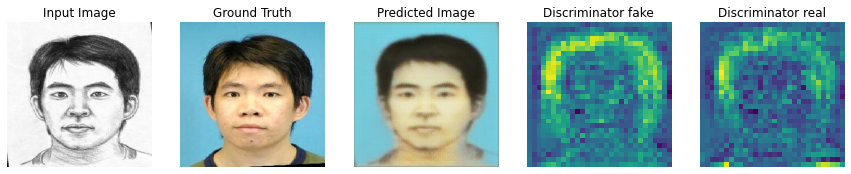

Epoch:  3
.........


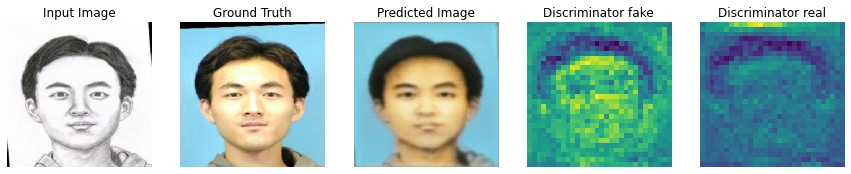

Epoch:  4
.........


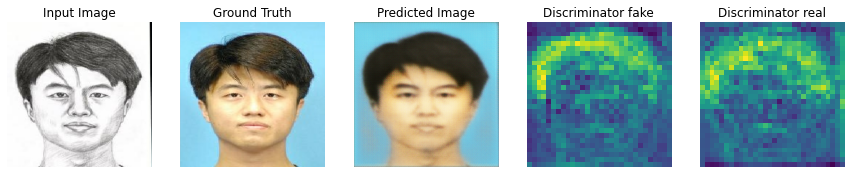

Epoch:  5
.........


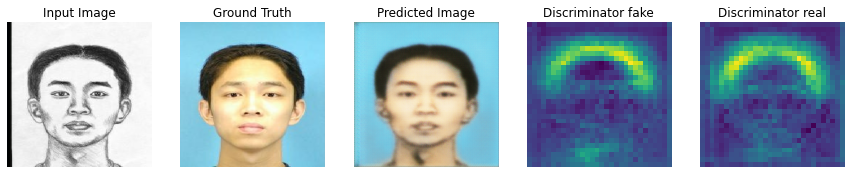

Epoch:  6
.........


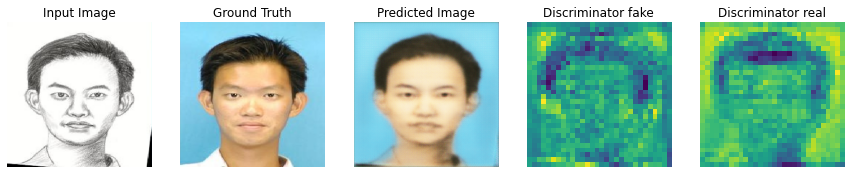

Epoch:  7
.........


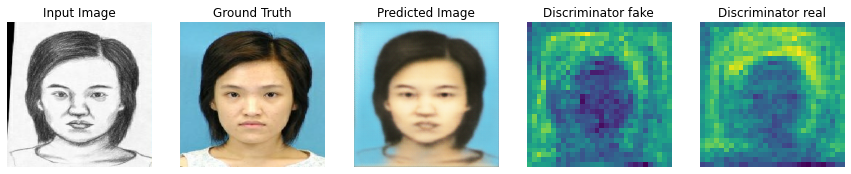

Epoch:  8
.........


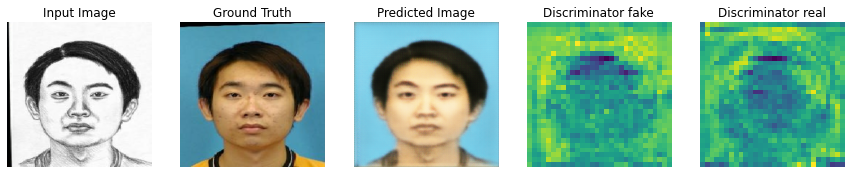

Epoch:  9
.........


In [64]:
fit(train_dataset, EPOCHS, test_dataset)

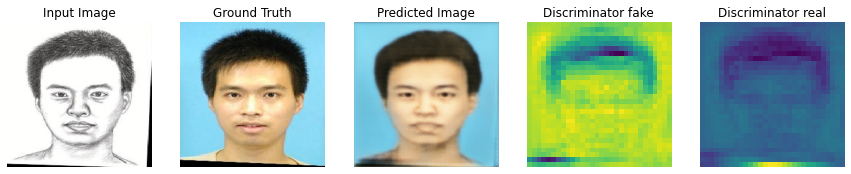

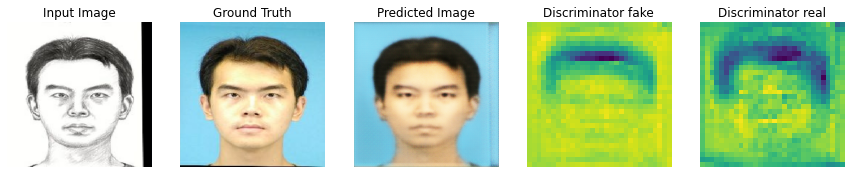

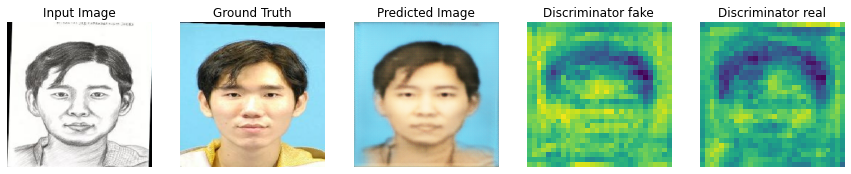

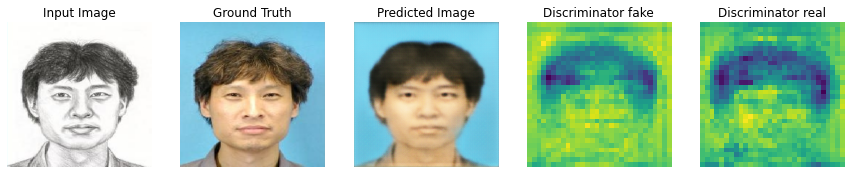

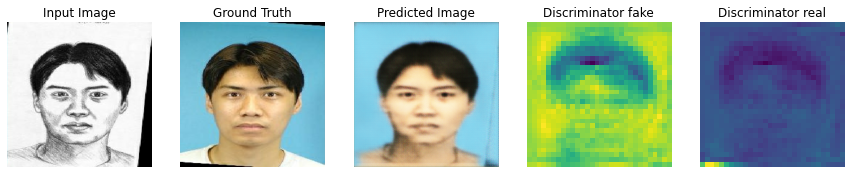

In [65]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [66]:
tf.saved_model.save(generator, path+"/pix2pix/")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/dataset/pix2pix/assets


In [67]:
loaded = tf.saved_model.load(path+"/pix2pix/")
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']


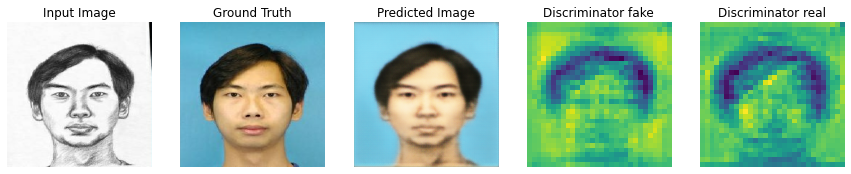

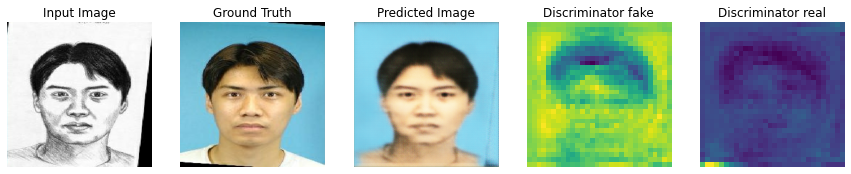

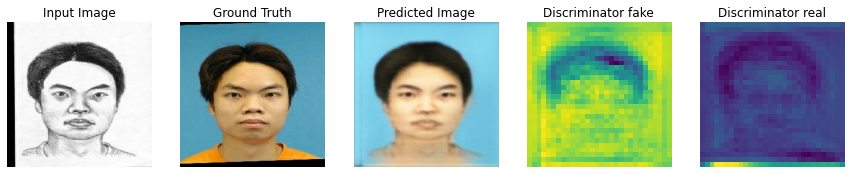

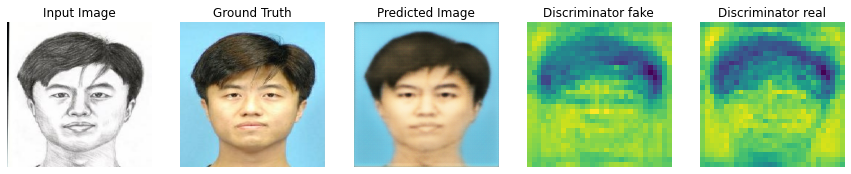

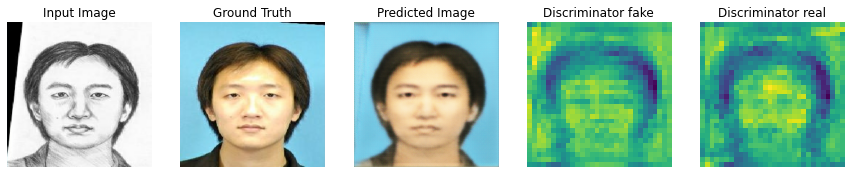

In [68]:
for inp, tar in test_dataset.take(5):
  generate_images(loaded, inp, tar) 

**Generating Sketch To Face Images**

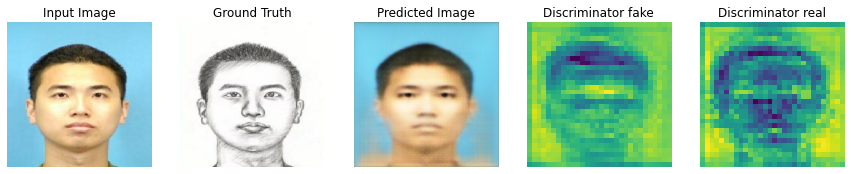

Epoch:  0
.........


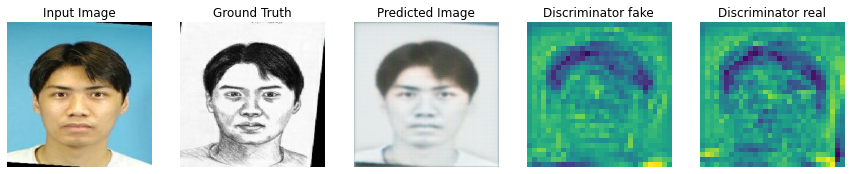

Epoch:  1
.........


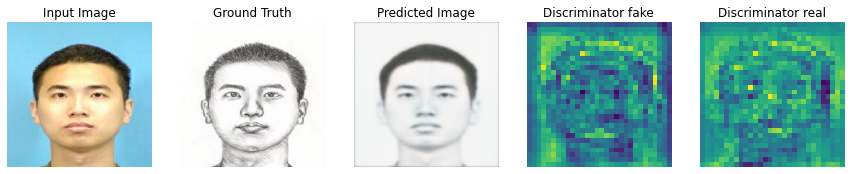

Epoch:  2
.........


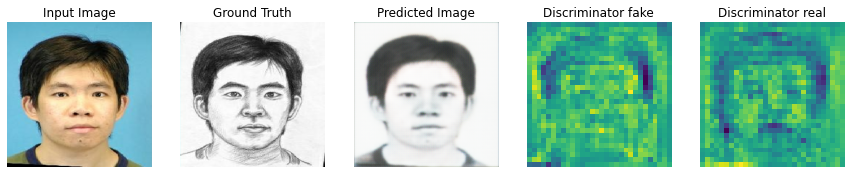

Epoch:  3
.........


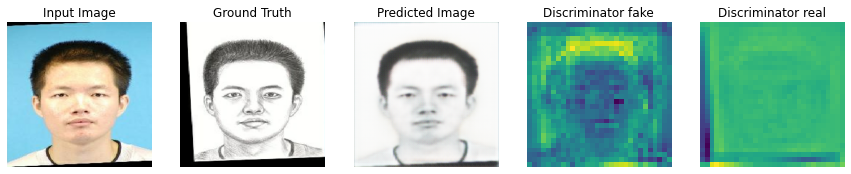

Epoch:  4
.........


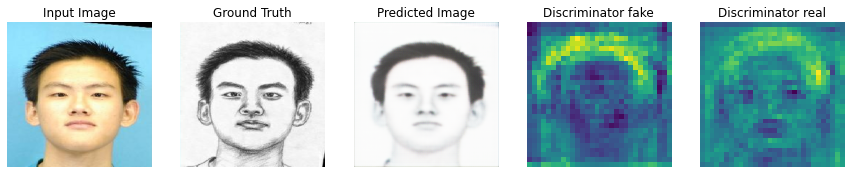

Epoch:  5
.........


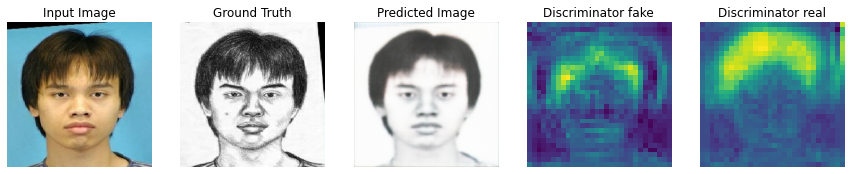

Epoch:  6
.........


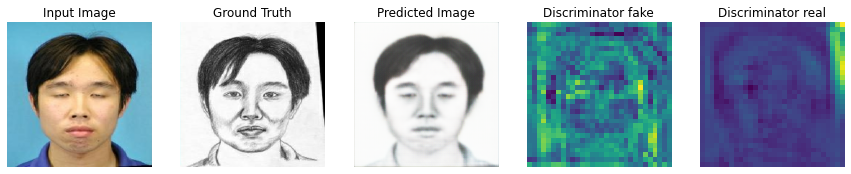

Epoch:  7
.........


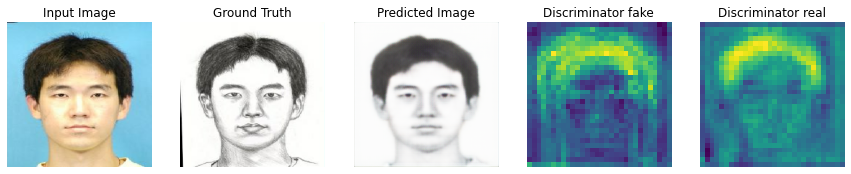

Epoch:  8
.........


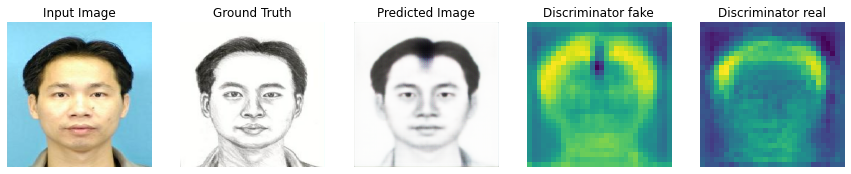

Epoch:  9
.........


In [69]:
fit(train_dataset_f2s, EPOCHS, test_dataset_f2s)

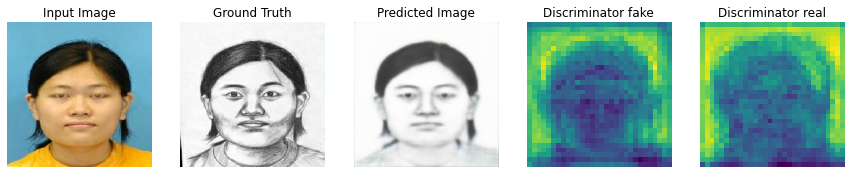

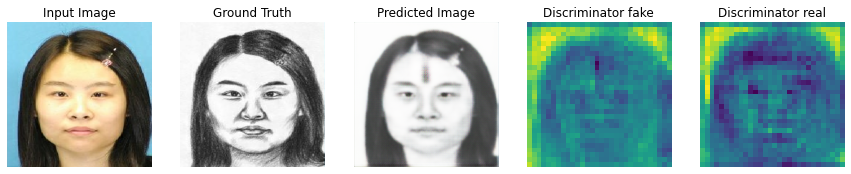

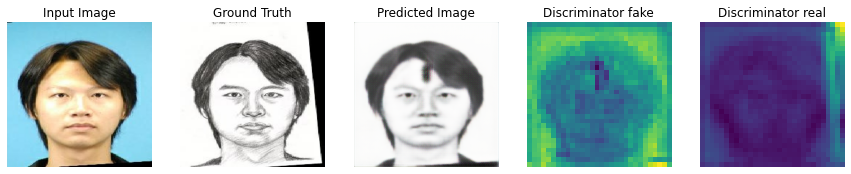

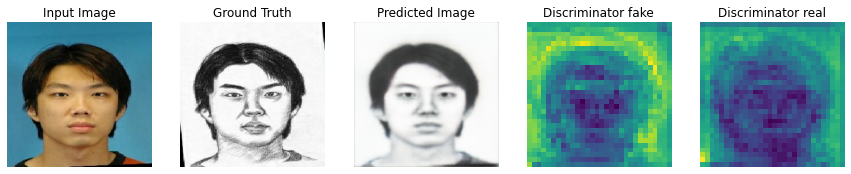

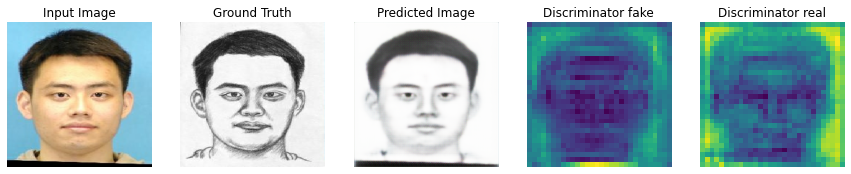

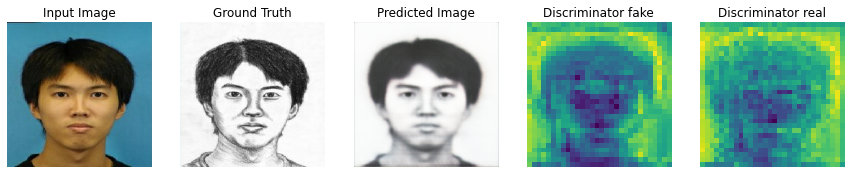

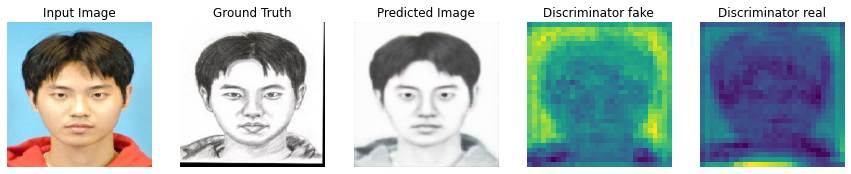

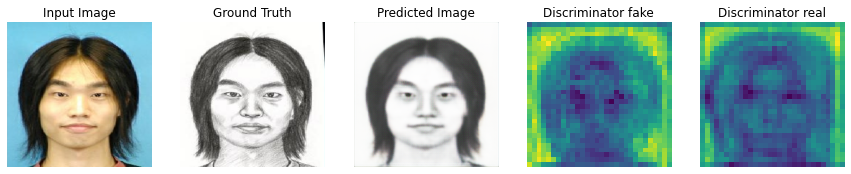

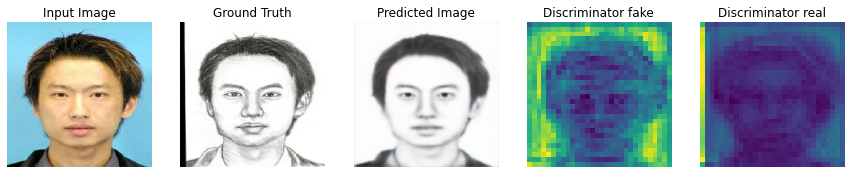

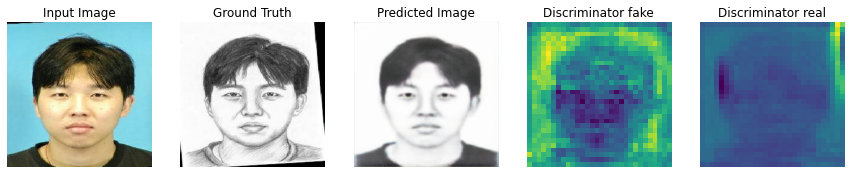

In [70]:
for inp, tar in test_dataset.take(50):
  generate_images(generator, tar, inp)